**Práctica 13: Análisis de imagenes**

Es bastante común que haya información disponible que está en formato de imágenes o videos. De un video se pueden extraer los frames (es decir, las imágenes individuales cuya secuencia compone el video) y luego aplicar técnicas de procesamiento de imágenes a los frames, siguido por algoritmos que comparan y combinan información entre frames por ejemplo para seguir a un objeto.

La librería [OpenCV](https://opencv.org/) tiene mucha funcionalidad para el análisis de imágenes y cuenta con bindings para python: pip3 install opencv-python y luego import cv2 dentro de python3 proporciona acceso a esta funcionalidad.

Otra librería útil para acceder información de imágenes es [Pillow](https://pillow.readthedocs.io/en/stable/): pip3 install Pillow y luego import PIL. 

Para el estudio de caso, se cuenta con [apuntes hechas a mano por los estudiantes](https://elisa.dyndns-web.com/teaching/mat/discretas/ad18/) por semana. Se sabe cuáles apuntes son de quíen ya que el nombre de archivo es la matrícula. Fueron escaneados en formato PDF, por lo cual primero hay que extraer las imágenes de las páginas en un formato que permite acceso a los pixeles como por ejemplo PNG. Esto se logra con [ImageMagick](https://www.imagemagick.org/) con teniendo [ejemplo1.pdf](https://elisa.dyndns-web.com/teaching/mat/discretas/ad18/semana_1/1657759.pdf) en la carpeta en la cual se ejecuta la instrucción

convert -verbose -density 150 -trim ejemplo1.pdf -quality 100 -flatten -sharpen 0x1.0 ejemplo1.png

lo que da como salida

/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-15481xBQ6rivbt1D1 PNG 1275x1650 1275x1650+0+0 8-bit sRGB 4271550B 0.070u 0:00.059
ejemplo1.pdf PDF 1275x1650 1275x1650+0+0 16-bit sRGB 4271550B 0.000u 0:00.000
ejemplo1.pdf=>ejemplo.png PDF 1275x1650 1275x1650+0+0 16-bit sRGB 11.675MiB 13.170u 0:13.200
[ghostscript library 9.21] -sstdout=%stderr -dQUIET -dSAFER -dBATCH -dNOPAUSE -dNOPROMPT -dMaxBitmap=500000000 -dAlignToPixels=0 -dGridFitTT=2 '-sDEVICE=pngalpha' -dTextAlphaBits=4 -dGraphicsAlphaBits=4 '-r150x150'  '-sOutputFile=/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-15481xBQ6rivbt1D%d' '-f/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-1548ofXTaI1ABwut' '-f/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-1548lHElv_31otpl'

para crear un ejemplo1.png (si el PDF contiene múltiples páginas, convert creará múltiples PNGs con números de página asignados).

![ejemplo1.png](https://elisa.dyndns-web.com/teaching/comp/datasci/ejemplo1.png)

Vamos a partir con la siguiente hipótesis: la cantidad de notas que ha tomado un alumno se puede expresar numéricamente con la cantidad de pixeles de lápiz o pluma; muchas páginas de texto muy grande con mucho espacio corresponden a pocas páginas de texto chico con poco espacio.

Lo primero que habrá que hacer es eliminar el color de fondo en el caso que las hojas hayan sido de color, igual como convertir todo el texto a un mismo color en el caso que el autor haya utilizado múltiples colores diferentes en sus notas. El proceso de forzar un fondo blanco y un texto negro se conoce como la binarización de una imagen. Se puede hacer en ImageMagick, pero también en Pillow; para prácticar, hágamoslo en Python.

(1275, 1650)


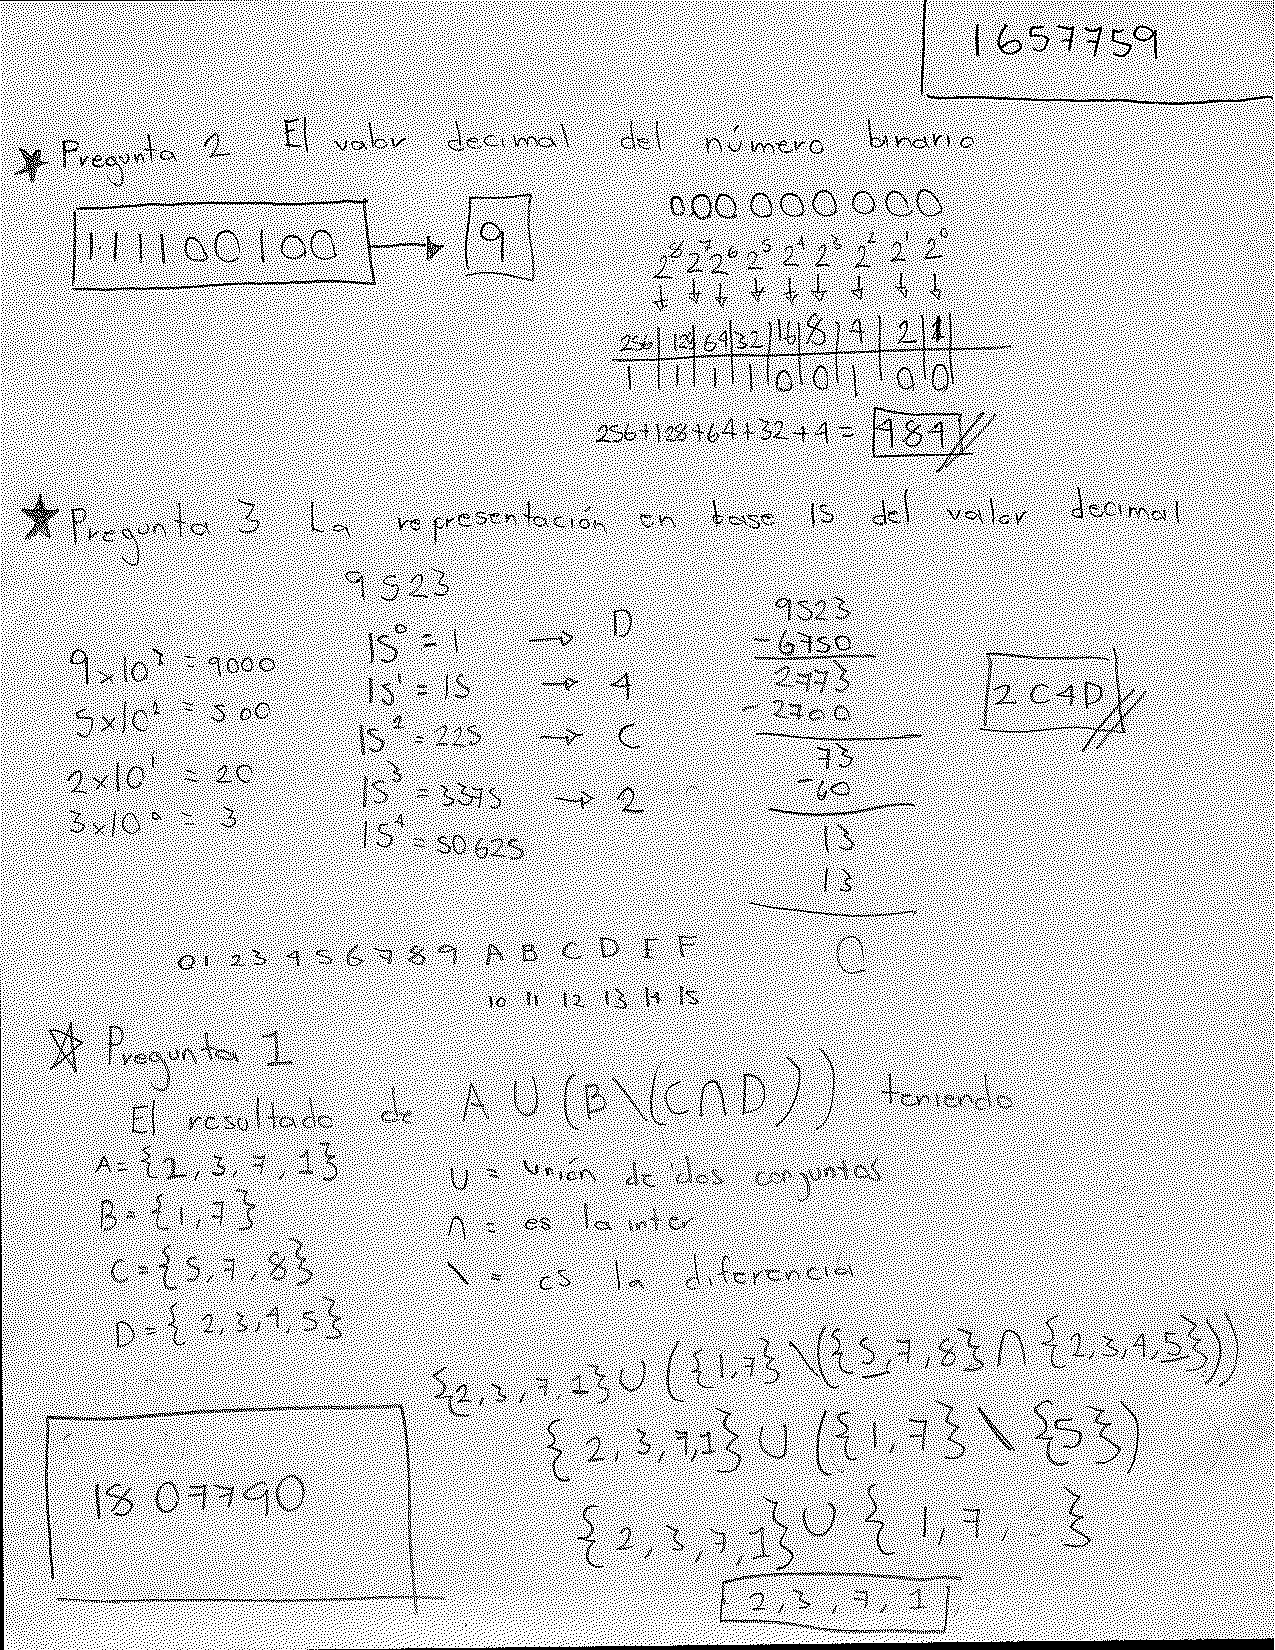

In [13]:
import ssl
import requests
from PIL import Image
 
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

imagen = Image.open(requests.get("https://elisa.dyndns-web.com/teaching/comp/datasci/ejemplo1.png", stream = True).raw) 
nuevo = imagen.convert('1') 
print(nuevo.size)
nuevo

Pues, es blanco y negro, pero se le ve ![la textura del papel aún en lugar de un fondo blanco](https://elisa.dyndns-web.com/teaching/comp/datasci/detalle.png).

Vamos a eliminar todos los pixeles negros _aislados_ que no tienen ningún otro pixel negro adyacente.

295226 pixeles negros aislados eliminados


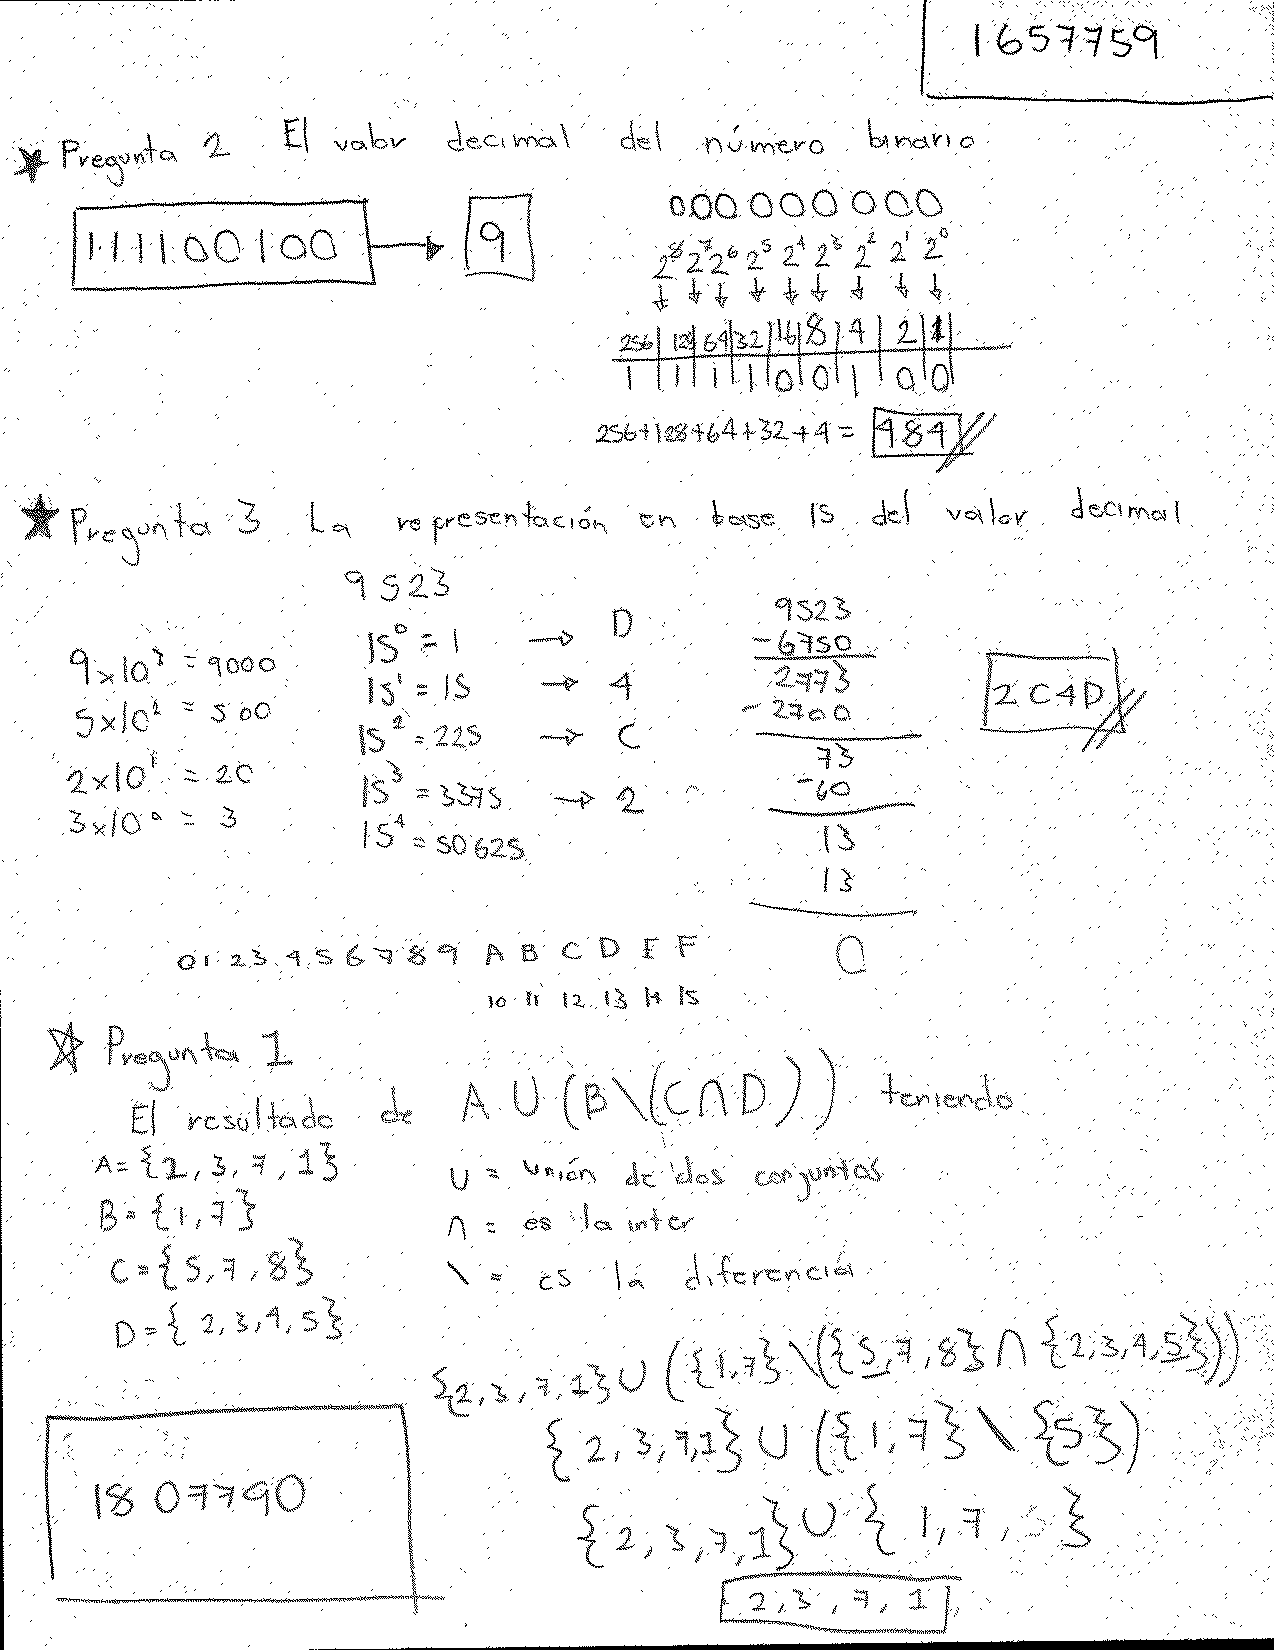

In [22]:
import ssl
import requests
from PIL import Image
 
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

imagen = Image.open(requests.get("https://elisa.dyndns-web.com/teaching/comp/datasci/ejemplo1.png", stream = True).raw) 
nuevo = imagen.convert('1') 
P = nuevo.load()
ancho, altura = nuevo.size
borrados = 0
vecinos = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
for fila in range(altura):
    for columna in range(ancho):
        if P[columna, fila] == 0: # pixel es negro
            tiene = False
            for (df, dc) in vecinos:
                vf = fila + df
                vc = columna + dc
                if vf >= 0 and vc >= 0 and vf < altura and vc < ancho: # si existe el vecino
                    if P[vc, vf] == 0:
                        tiene = True
                        break # no hace falta seguir examinando
            if not tiene: # no tenía vecino negro
                P[columna, fila] = 255 # será blanco
                borrados += 1
print(borrados, "pixeles negros aislados eliminados")
nuevo

Ya se eliminó algo del ruido del fondo, pero aún no la totalidad. Vamos a ver qué pasa si borramos también los que tienen un sólo vecino negro.

304695 pixeles negros eliminados


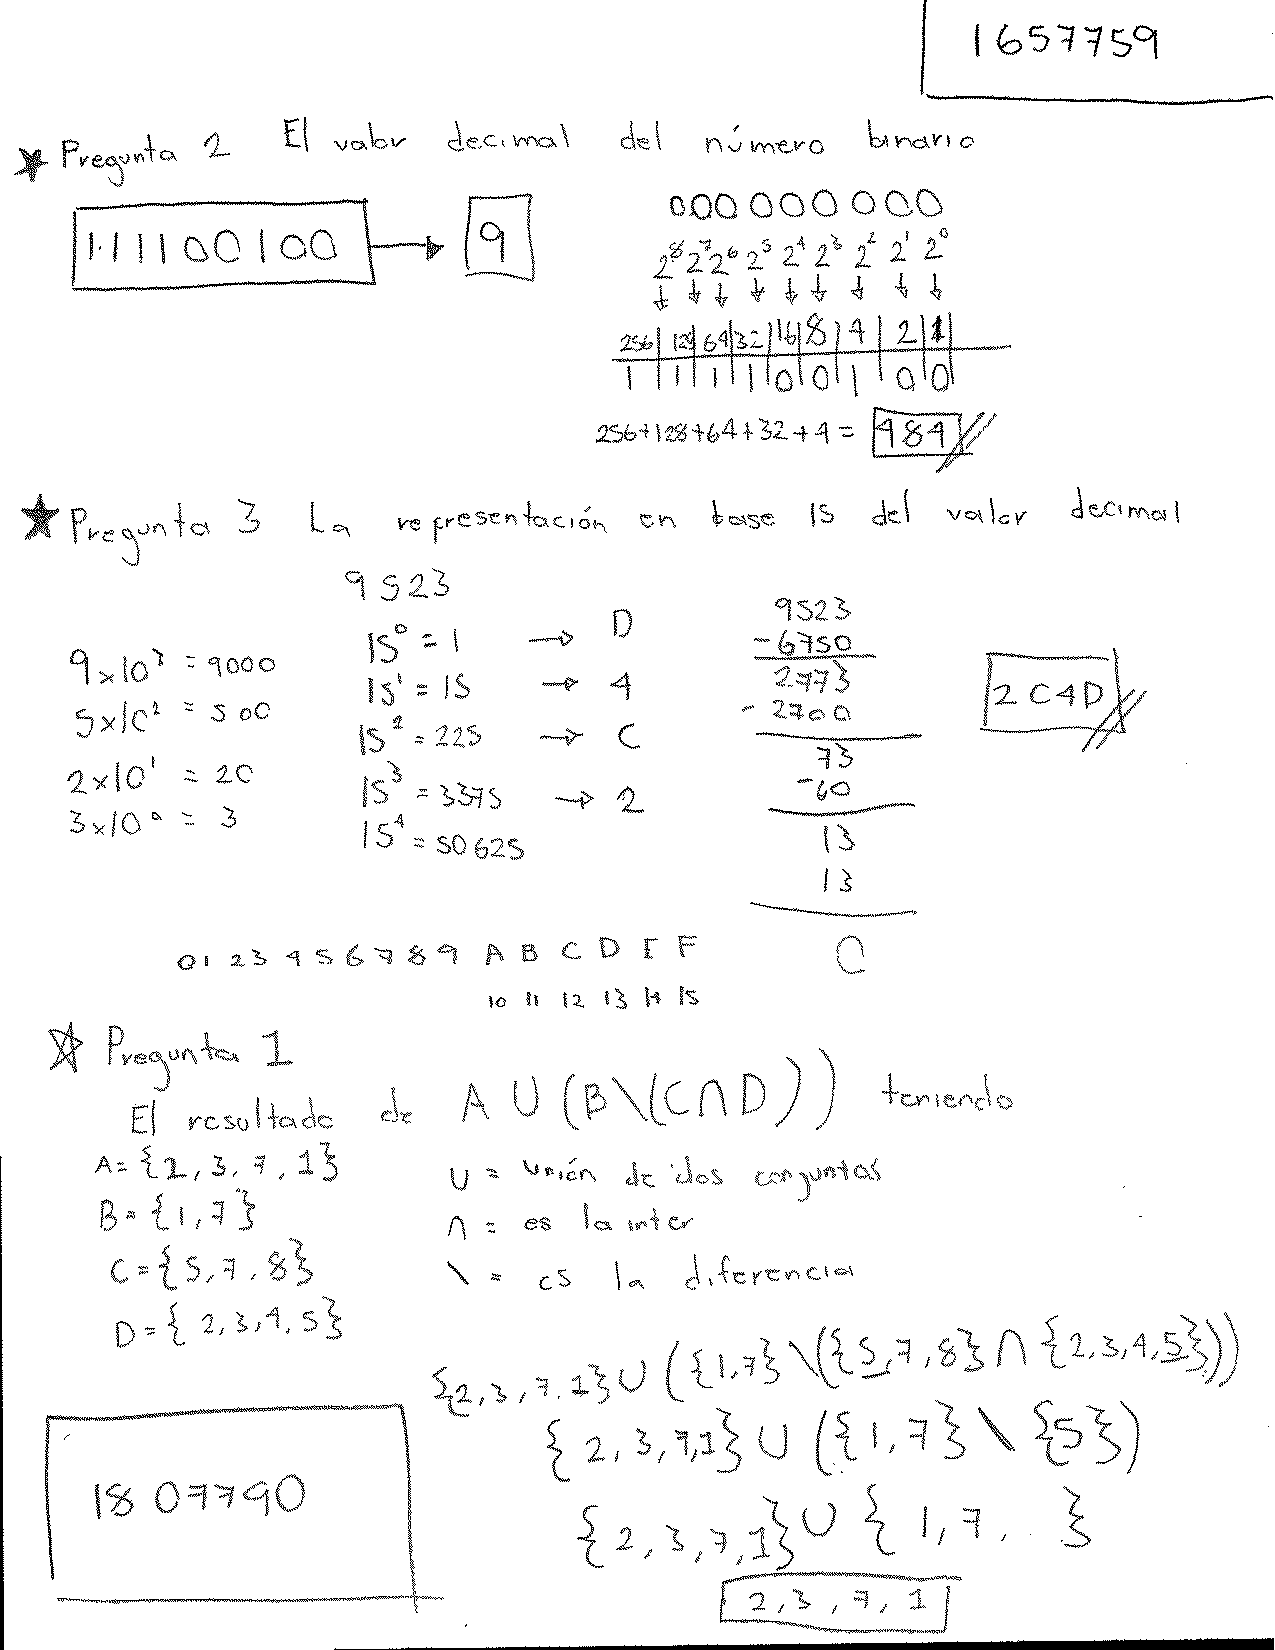

In [24]:
import ssl
import requests
from PIL import Image
 
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

imagen = Image.open(requests.get("https://elisa.dyndns-web.com/teaching/comp/datasci/ejemplo1.png", stream = True).raw) 
nuevo = imagen.convert('1') 
P = nuevo.load()
ancho, altura = nuevo.size
borrados = 0
vecinos = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
for fila in range(altura):
    for columna in range(ancho):
        if P[columna, fila] == 0: # pixel es negro
            contador = 0
            for (df, dc) in vecinos:
                vf = fila + df
                vc = columna + dc
                if vf >= 0 and vc >= 0 and vf < altura and vc < ancho: # si existe el vecino
                    if P[vc, vf] == 0:
                        contador += 1
            if contador < 2: # uno o cero vecinos negros
                P[columna, fila] = 255 # será blanco
                borrados += 1
print(borrados, "pixeles negros eliminados")
nuevo

Mucho mejor, ¿no? Falta además eliminar los efectos de borde que son de escaneo. Eso se logra eliminando zonas contínuas de negro que tocan el borde. Esto se conoce como "bucket fill" o "flood fill" y se puede implementar con un DFS (depth-first search) si la librería no lo tiene. Pillow sí tiene un PIL.ImageDraw.floodfill(), pero funciona solamente en modo RGB, no en imágenes binarizados, por lo cual habrá que hacerlo aparte.

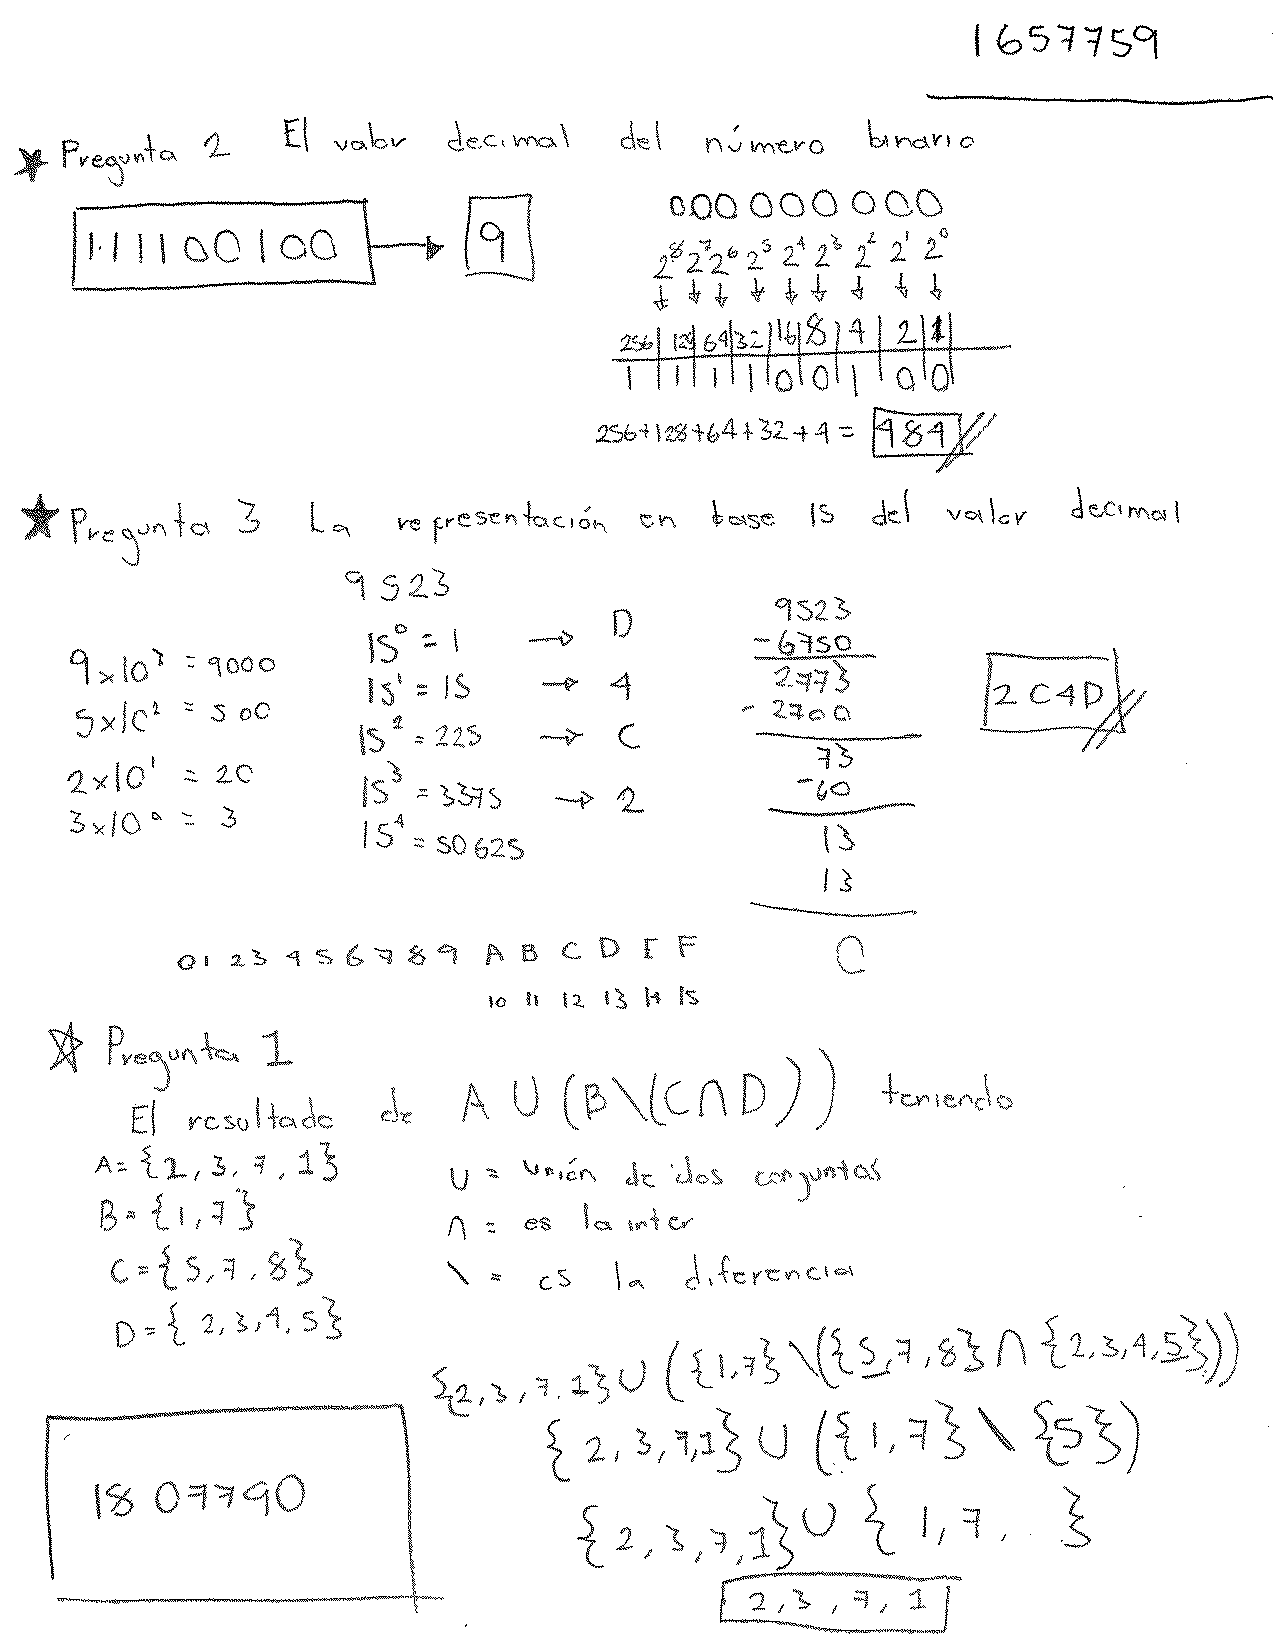

In [2]:
import ssl
import requests
from PIL import Image, ImageDraw
 
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

imagen = Image.open(requests.get("https://elisa.dyndns-web.com/teaching/comp/datasci/ejemplo1.png", stream = True).raw) 
n = imagen.convert('1') 
w, h = n.size
rgb = n.convert('RGB')
P = rgb.load()
negro = (0, 0, 0)
blanco = (255, 255, 255)
for f in range(h): # bordes verticales
    if P[0, f] == negro:
        ImageDraw.floodfill(rgb, (0, f), blanco)
    if P[w - 1, f] == negro:
        ImageDraw.floodfill(rgb, (w - 1, f), blanco)
for c in range(w): # bordes horizontales
    if P[c, 0] == negro:
        ImageDraw.floodfill(rgb, (c, 0), blanco)
    if P[c, h - 1] == negro:
        ImageDraw.floodfill(rgb, (c, h - 1), blanco) 
n = rgb.convert('1') 
P = n.load()
V = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
for f in range(1, h - 1): # sin bordes ahora
    for c in range(1, w - 1):
        if P[c, f] == 0: 
            cont = 0
            for (df, dc) in V:
                if P[c + dc, f + df] == 0: # siempre existen
                    cont += 1
            if cont < 2:
                P[c, f] = 255 #  blanco
n

Mucho mejor. Ahora podemos contar qué porcentaje de los pixeles quedaron negros para tener una forma de cuantificar cuántos apuntes hizo el alumno en esa semana.

In [3]:
import ssl
import requests
from PIL import Image, ImageDraw
 
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

imagen = Image.open(requests.get("https://elisa.dyndns-web.com/teaching/comp/datasci/ejemplo1.png", stream = True).raw) 
n = imagen.convert('1') 
w, h = n.size
rgb = n.convert('RGB')
P = rgb.load()
negro = (0, 0, 0)
blanco = (255, 255, 255)
for f in range(h): # bordes verticales
    if P[0, f] == negro:
        ImageDraw.floodfill(rgb, (0, f), blanco)
    if P[w - 1, f] == negro:
        ImageDraw.floodfill(rgb, (w - 1, f), blanco)
for c in range(w): # bordes horizontales
    if P[c, 0] == negro:
        ImageDraw.floodfill(rgb, (c, 0), blanco)
    if P[c, h - 1] == negro:
        ImageDraw.floodfill(rgb, (c, h - 1), blanco) 
n = rgb.convert('1') 
P = n.load()
V = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
negros = 0
totales = w * h
for f in range(1, h - 1): # sin bordes ahora
    for c in range(1, w - 1):
        if P[c, f] == 0: 
            cont = 0
            for (df, dc) in V:
                if P[c + dc, f + df] == 0: # siempre existen
                    cont += 1
            if cont < 2:
                P[c, f] = 255 #  blanco
            else:
                negros += 1
print('{:.2f} porciento negro'.format(100 * negros / totales))

2.48 porciento negro


Comparemos con otros alumnos y otras semanas. 

In [ ]:
curl -o ejemplo2.pdf https://elisa.dyndns-web.com/teaching/mat/discretas/ad18/semana_10/1741173.pdf
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3857k  100 3857k    0     0  32.6M      0 --:--:-- --:--:-- --:--:-- 32.7M

curl -o ejemplo3.pdf https://elisa.dyndns-web.com/teaching/mat/discretas/ad18/semana_5/1810042.pdf
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3585k  100 3585k    0     0  31.8M      0 --:--:-- --:--:-- --:--:-- 32.1M

curl -o ejemplo4.pdf https://elisa.dyndns-web.com/teaching/mat/discretas/ad18/semana_4/1824168.pdf
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2813k  100 2813k    0     0  27.7M      0 --:--:-- --:--:-- --:--:-- 28.0M

curl -o ejemplo5.pdf https://elisa.dyndns-web.com/teaching/mat/discretas/ad18/semana_13/1795493.pdf
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6375k  100 6375k    0     0  26.5M      0 --:--:-- --:--:-- --:--:-- 26.6M

ls -la ejemplo*.pdf
-rw-r--r--@ 1 elisa  staff  3010728 Jan 14 12:27 ejemplo1.pdf
-rw-r--r--@ 1 elisa  staff  3950069 Jan 14 13:24 ejemplo2.pdf
-rw-r--r--@ 1 elisa  staff  3671493 Jan 14 13:24 ejemplo3.pdf
-rw-r--r--@ 1 elisa  staff  2880959 Jan 14 13:54 ejemplo4.pdf
-rw-r--r--@ 1 elisa  staff  6528456 Jan 14 13:22 ejemplo5.pdf

Con [PDFtk](https://www.pdflabs.com/tools/pdftk-server/) se puede ver cuántas páginas tienen.

In [ ]:
for file in `ls -1 ejemplo*.pdf`; do echo $file; pdftk $file dump_data | grep NumberOfPages; done

ejemplo1.pdf
NumberOfPages: 1
ejemplo2.pdf
NumberOfPages: 1
ejemplo3.pdf
NumberOfPages: 1
ejemplo4.pdf
NumberOfPages: 1
ejemplo5.pdf
NumberOfPages: 2

Ya que el último contiene dos páginas, le modificamos la conversión para que saque cada página en un PNG separado. Con los demás basta lo de siempre.

In [ ]:
convert -verbose -density 150 -trim ejemplo2.pdf -quality 100 -flatten -sharpen 0x1.0 ejemplo2.png

/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-1765DkHcafSWtkdr1 PNG 1275x1650 1275x1650+0+0 8-bit sRGB 4.94133MiB 0.070u 0:00.060
ejemplo2.pdf PDF 1275x1650 1275x1650+0+0 16-bit sRGB 4.94133MiB 0.000u 0:00.009
ejemplo2.pdf=>ejemplo2.png PDF 1275x1650 1275x1650+0+0 16-bit sRGB 12.9901MiB 3.510u 0:03.529
[ghostscript library 9.21] -sstdout=%stderr -dQUIET -dSAFER -dBATCH -dNOPAUSE -dNOPROMPT -dMaxBitmap=500000000 -dAlignToPixels=0 -dGridFitTT=2 '-sDEVICE=pngalpha' -dTextAlphaBits=4 -dGraphicsAlphaBits=4 '-r150x150'  '-sOutputFile=/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-1765DkHcafSWtkdr%d' '-f/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-17655KRfM09IkuHu' '-f/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-17653xERwTPLzzTS'

convert -verbose -density 150 -trim ejemplo3.pdf -quality 100 -flatten -sharpen 0x1.0 ejemplo3.png

/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-17682Q9Hkv9KQVBh1 PNG 1275x1650 1275x1650+0+0 8-bit sRGB 4.73237MiB 0.070u 0:00.059
ejemplo3.pdf PDF 1275x1650 1275x1650+0+0 16-bit sRGB 4.73237MiB 0.000u 0:00.000
ejemplo3.pdf=>ejemplo3.png PDF 1275x1650 1275x1650+0+0 16-bit sRGB 12.927MiB 3.520u 0:03.539
[ghostscript library 9.21] -sstdout=%stderr -dQUIET -dSAFER -dBATCH -dNOPAUSE -dNOPROMPT -dMaxBitmap=500000000 -dAlignToPixels=0 -dGridFitTT=2 '-sDEVICE=pngalpha' -dTextAlphaBits=4 -dGraphicsAlphaBits=4 '-r150x150'  '-sOutputFile=/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-17682Q9Hkv9KQVBh%d' '-f/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-1768BUJqx_k23Z7A' '-f/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-1768xFcpi23wu8ZA'

convert -verbose -density 150 -trim ejemplo4.pdf -quality 100 -flatten -sharpen 0x1.0 ejemplo4.png

/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-1800fRuo5V3HDzP21 PNG 1275x1650 1275x1650+0+0 8-bit sRGB 3.9085MiB 0.070u 0:00.059
ejemplo4.pdf PDF 1275x1650 1275x1650+0+0 16-bit sRGB 3.9085MiB 0.000u 0:00.000
ejemplo4.pdf=>ejemplo4.png PDF 1275x1650 1275x1650+0+0 16-bit sRGB 11.6256MiB 13.320u 0:13.319
[ghostscript library 9.21] -sstdout=%stderr -dQUIET -dSAFER -dBATCH -dNOPAUSE -dNOPROMPT -dMaxBitmap=500000000 -dAlignToPixels=0 -dGridFitTT=2 '-sDEVICE=pngalpha' -dTextAlphaBits=4 -dGraphicsAlphaBits=4 '-r150x150'  '-sOutputFile=/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-1800fRuo5V3HDzP2%d' '-f/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-1800pZAeFFleERSI' '-f/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-1800D-i5A7sVkmjp'

convert -verbose -density 150 -trim ejemplo5.pdf -quality 100 -flatten -sharpen 0x1.0  ejemplo5-%02d.png

/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-1730JsieSJvUPvxr1 PNG 1275x1650 1275x1650+0+0 8-bit sRGB 4.21594MiB 0.060u 0:00.069
/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-1730JsieSJvUPvxr2 PNG 1275x1650 1275x1650+0+0 8-bit sRGB 4.52208MiB 0.070u 0:00.060
ejemplo5.pdf[0] PDF 1275x1650 1275x1650+0+0 16-bit sRGB 4.21594MiB 0.070u 0:00.060
ejemplo5.pdf[1] PDF 1275x1650 1275x1650+0+0 16-bit sRGB 4.21594MiB 0.000u 0:00.000
ejemplo5.pdf=>ejemplo5-00.png PDF 1275x1650 1275x1650+0+0 16-bit sRGB 11.9307MiB 11.820u 0:11.830
[ghostscript library 9.21] -sstdout=%stderr -dQUIET -dSAFER -dBATCH -dNOPAUSE -dNOPROMPT -dMaxBitmap=500000000 -dAlignToPixels=0 -dGridFitTT=2 '-sDEVICE=pngalpha' -dTextAlphaBits=4 -dGraphicsAlphaBits=4 '-r150x150'  '-sOutputFile=/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-1730JsieSJvUPvxr%d' '-f/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-1730JEO3pDGUhB5F' '-f/var/folders/qj/1gw209fx1qb31lz61njz69k00000gn/T/magick-1730-ZZ0HHQT1Bng'

ls -la ejemplo*.png
-rw-r--r--@ 1 elisa  staff  12242166 Jan 14 13:27 ejemplo1.png
-rw-r--r--@ 1 elisa  staff  13621059 Jan 14 13:50 ejemplo2.png
-rw-r--r--@ 1 elisa  staff  13554902 Jan 14 13:50 ejemplo3.png
-rw-r--r--@ 1 elisa  staff  12190349 Jan 14 13:55 ejemplo4.png
-rw-r--r--@ 1 elisa  staff  12510238 Jan 14 13:40 ejemplo5-00.png
-rw-r--r--@ 1 elisa  staff   4722107 Jan 14 13:40 ejemplo5-01.png

Combinemos los dos PNG del quinto ejemplo en uno solo con más ImageMagick (+append los junta horizontalmente, -append verticalmente):

In [ ]:
convert ejemplo5*.png -append ejemplo5.png
ls -la ejemplo*.png
-rw-r--r--@ 1 elisa  staff  12242166 Jan 14 13:27 ejemplo1.png
-rw-r--r--@ 1 elisa  staff  13621059 Jan 14 13:50 ejemplo2.png
-rw-r--r--@ 1 elisa  staff  13554902 Jan 14 13:50 ejemplo3.png
-rw-r--r--@ 1 elisa  staff  12190349 Jan 14 13:55 ejemplo4.png
-rw-r--r--@ 1 elisa  staff  12510238 Jan 14 13:40 ejemplo5-00.png
-rw-r--r--@ 1 elisa  staff   4722107 Jan 14 13:40 ejemplo5-01.png
-rw-r--r--@ 1 elisa  staff  18805438 Jan 14 13:43 ejemplo5.png
rm ejemplo5-*.png

In [25]:
import ssl
import requests
from PIL import Image, ImageDraw
 
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

for ejemplo in range(1, 6): # de uno a cinco
    url = 'https://elisa.dyndns-web.com/teaching/comp/datasci/ejemplo{:d}.png'.format(ejemplo)
    imagen = Image.open(requests.get(url, stream = True).raw) 
    n = imagen.convert('1') 
    w, h = n.size
    rgb = n.convert('RGB')
    P = rgb.load()
    negro = (0, 0, 0)
    blanco = (255, 255, 255)
    for f in range(h): # bordes verticales
        if P[0, f] == negro:
            ImageDraw.floodfill(rgb, (0, f), blanco)
        if P[w - 1, f] == negro:
            ImageDraw.floodfill(rgb, (w - 1, f), blanco)
    for c in range(w): # bordes horizontales
        if P[c, 0] == negro:
            ImageDraw.floodfill(rgb, (c, 0), blanco)
        if P[c, h - 1] == negro:
            ImageDraw.floodfill(rgb, (c, h - 1), blanco) 
    n = rgb.convert('1') 
    P = n.load()
    V = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    negros = 0
    for f in range(1, h - 1): # sin bordes ahora
        for c in range(1, w - 1):
            if P[c, f] == 0: 
                cont = 0
                for (df, dc) in V:
                    if P[c + dc, f + df] == 0: # siempre existen
                        cont += 1
                if cont < 2:
                    P[c, f] = 255 #  blanco
                else:
                    negros += 1
    # ya no conviene normalizar porque el tamaño varia (1 vs. 2 páginas)
    print('Ejemplo {:d}:\t{:d} pixeles de texto'.format(ejemplo, negros)) 

Ejemplo 1:	52238 pixeles de texto
Ejemplo 2:	49236 pixeles de texto
Ejemplo 3:	46919 pixeles de texto
Ejemplo 4:	11692 pixeles de texto
Ejemplo 5:	970810 pixeles de texto


Antes de saltar a conclusiones, hay que _ver_ si quedaron bien las imágenes binarizadas.

In [ ]:
import ssl
import requests
from PIL import Image, ImageDraw
 
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

for ejemplo in range(1, 6): # de uno a cinco
    url = 'https://elisa.dyndns-web.com/teaching/comp/datasci/ejemplo{:d}.png'.format(ejemplo)
    imagen = Image.open(requests.get(url, stream = True).raw) 
    n = imagen.convert('1') 
    w, h = n.size
    rgb = n.convert('RGB')
    P = rgb.load()
    negro = (0, 0, 0)
    blanco = (255, 255, 255)
    for f in range(h): # bordes verticales
        if P[0, f] == negro:
            ImageDraw.floodfill(rgb, (0, f), blanco)
        if P[w - 1, f] == negro:
            ImageDraw.floodfill(rgb, (w - 1, f), blanco)
    for c in range(w): # bordes horizontales
        if P[c, 0] == negro:
            ImageDraw.floodfill(rgb, (c, 0), blanco)
        if P[c, h - 1] == negro:
            ImageDraw.floodfill(rgb, (c, h - 1), blanco) 
    n = rgb.convert('1') 
    P = n.load()
    V = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    for f in range(1, h - 1): # sin bordes ahora
        for c in range(1, w - 1):
            if P[c, f] == 0: 
                cont = 0
                for (df, dc) in V:
                    if P[c + dc, f + df] == 0: # siempre existen
                        cont += 1
                if cont < 2:
                    P[c, f] = 255 #  blanco
    n.save('bin_{:d}.png'.format(ejemplo))

![bin_1.png](https://elisa.dyndns-web.com/teaching/comp/datasci/bin_1.png)
![bin_2.png](https://elisa.dyndns-web.com/teaching/comp/datasci/bin_2.png)
![bin_3.png](https://elisa.dyndns-web.com/teaching/comp/datasci/bin_3.png)
![bin_4.png](https://elisa.dyndns-web.com/teaching/comp/datasci/bin_4.png)
![bin_5.png](https://elisa.dyndns-web.com/teaching/comp/datasci/bin_5.png)

Pues, no funcionó la misma regla con todos. El uno se ve bien, como ya sabíamos. El dos y tres siguen con ruidos, rayas pequeñas. El cuatro se ve casi bien, aunque algo borrado y el cinco es un desmadre total de ruido de fondo. La binarización no funciona en todos los casos. 

Intentemos otra forma: forcemos primero a blanco, desde RGB, todos los colores no negros. Luego apenas binarizamos. Esto fallará si usaron plumas de color, pero debería ayudar con el ruido de fondo que ahora nos perjudica.

In [ ]:
import ssl
import requests
from PIL import Image, ImageDraw
 
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

negro = (0, 0, 0)
blanco = (255, 255, 255)
umbral = 90 # tomó un poco de búsqueda binaria para hallarle un valor que funcione
    
for ejemplo in range(1, 6): # de uno a cinco
    url = 'https://elisa.dyndns-web.com/teaching/comp/datasci/ejemplo{:d}.png'.format(ejemplo)
    imagen = Image.open(requests.get(url, stream = True).raw) 
    n = imagen.convert('RGB') 
    w, h = n.size
    P = n.load()
    for f in range(h): # bordes verticales
        if P[0, f] == negro:
            ImageDraw.floodfill(n, (0, f), blanco)
        if P[w - 1, f] == negro:
            ImageDraw.floodfill(n, (w - 1, f), blanco)
    for c in range(w): # bordes horizontales
        if P[c, 0] == negro:
            ImageDraw.floodfill(n, (c, 0), blanco)
        if P[c, h - 1] == negro:
            ImageDraw.floodfill(n, (c, h - 1), blanco) 
    for f in range(h): 
        for c in range(w):
            rgb = P[c, f]
            if max(rgb) - min(rgb) > umbral: # tiene un color que no es gris 
                P[c, f] = blanco
    b = n.convert('1') # binaricemos lo que queda
    b.save('rgb_{:d}.png'.format(ejemplo))

![rgb_1.png](https://elisa.dyndns-web.com/teaching/comp/datasci/rgb_1.png)
![rgb_2.png](https://elisa.dyndns-web.com/teaching/comp/datasci/rgb_2.png)
![rgb_3.png](https://elisa.dyndns-web.com/teaching/comp/datasci/rgb_3.png)
![rgb_4.png](https://elisa.dyndns-web.com/teaching/comp/datasci/rgb_4.png)
![rgb_5.png](https://elisa.dyndns-web.com/teaching/comp/datasci/rgb_5.png)

Mucho mejor. Recontemos los pixeles negros con esta nueva técnica.

In [36]:
import ssl
import requests
from PIL import Image, ImageDraw
 
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

negro = (0, 0, 0)
blanco = (255, 255, 255)
umbral = 90 
    
for ejemplo in range(1, 6): # de uno a cinco
    url = 'https://elisa.dyndns-web.com/teaching/comp/datasci/ejemplo{:d}.png'.format(ejemplo)
    imagen = Image.open(requests.get(url, stream = True).raw) 
    n = imagen.convert('RGB') 
    w, h = n.size
    P = n.load()
    for f in range(h): # bordes verticales
        if P[0, f] == negro:
            ImageDraw.floodfill(n, (0, f), blanco)
        if P[w - 1, f] == negro:
            ImageDraw.floodfill(n, (w - 1, f), blanco)
    for c in range(w): # bordes horizontales
        if P[c, 0] == negro:
            ImageDraw.floodfill(n, (c, 0), blanco)
        if P[c, h - 1] == negro:
            ImageDraw.floodfill(n, (c, h - 1), blanco) 
    for f in range(h): 
        for c in range(w):
            rgb = P[c, f]
            if max(rgb) - min(rgb) > umbral: # tiene un color que no es gris 
                P[c, f] = blanco
    b = n.convert('1') # binaricemos lo que queda
    P = b.load()
    negros = 0
    for f in range(h): 
        for c in range(w):
            if P[c, f] == 0:
                negros += 1
    print(ejemplo, negros)

1 43851
2 18490
3 25058
4 16762
5 150604


Vamos a ver si la información que tenemos aquí correlaciona con el tamaño del PDF o del PNG correspondiente: si el puro tamaño del archivo nos dice algo similar, no tiene caso todo este esfuerzo.

In [ ]:
ls -la ejemplo?.pdf | awk '{print $5}'
3010728
3950069
3671493
2880959
6528456

ls -la ejemplo?.png | awk '{print $5}'
12242166
13621059
13554902
12190349
18805438

ls -la rgb_*.png | awk '{print $5}'
35311
12616
15329
14446
102572

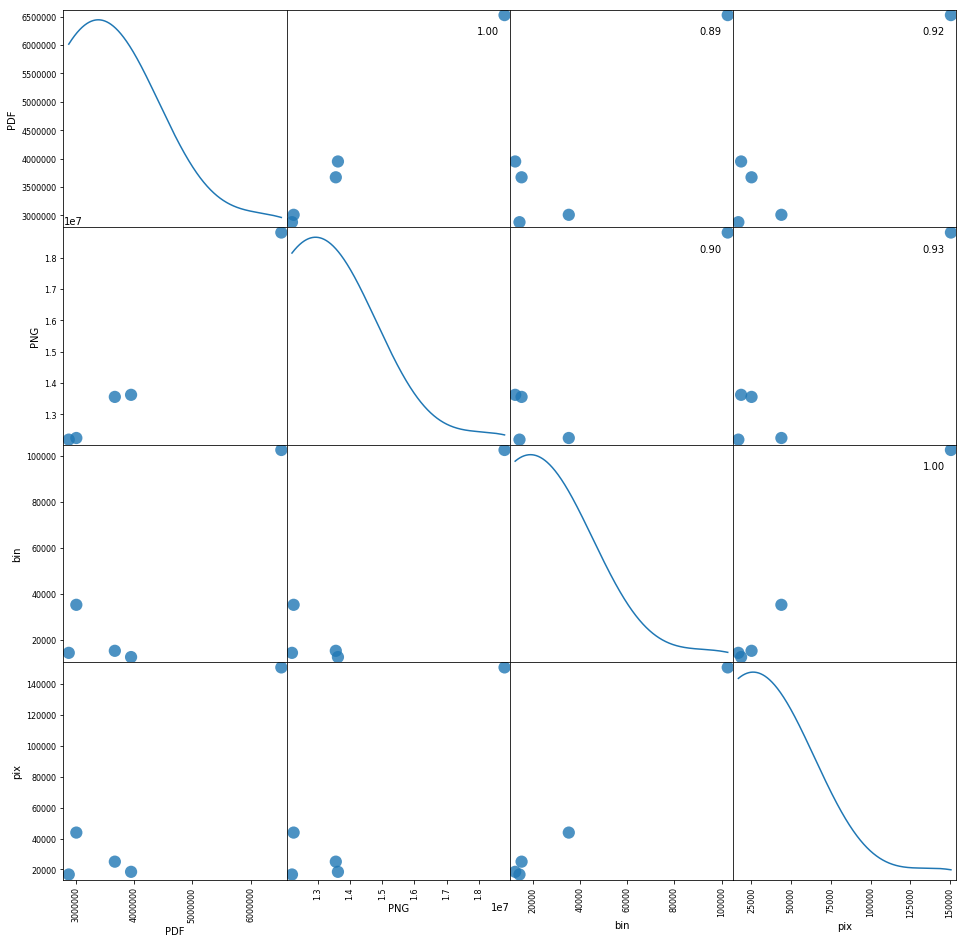

In [37]:
import ssl
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pandas.plotting import scatter_matrix

data = pd.DataFrame({'PDF': [3010728, 3950069, 3671493, 2880959, 6528456],\
                    'PNG': [12242166, 13621059, 13554902, 12190349, 18805438], \
                    'bin': [35311, 12616, 15329, 14446, 102572]})

if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

negro = (0, 0, 0)
blanco = (255, 255, 255)
umbral = 90 
    
pix = []
for ejemplo in range(1, 6): # de uno a cinco
    url = 'https://elisa.dyndns-web.com/teaching/comp/datasci/ejemplo{:d}.png'.format(ejemplo)
    imagen = Image.open(requests.get(url, stream = True).raw) 
    n = imagen.convert('RGB') 
    w, h = n.size
    P = n.load()
    for f in range(h): # bordes verticales
        if P[0, f] == negro:
            ImageDraw.floodfill(n, (0, f), blanco)
        if P[w - 1, f] == negro:
            ImageDraw.floodfill(n, (w - 1, f), blanco)
    for c in range(w): # bordes horizontales
        if P[c, 0] == negro:
            ImageDraw.floodfill(n, (c, 0), blanco)
        if P[c, h - 1] == negro:
            ImageDraw.floodfill(n, (c, h - 1), blanco) 
    for f in range(h): 
        for c in range(w):
            rgb = P[c, f]
            if max(rgb) - min(rgb) > umbral: # tiene un color que no es gris 
                P[c, f] = blanco
    b = n.convert('1') # binaricemos lo que queda
    P = b.load()
    negros = 0
    for f in range(h): 
        for c in range(w):
            if P[c, f] == 0:
                negros += 1
    pix.append(negros)

data['pix'] = pix
# visualización basado en la discusión de
# https://stackoverflow.com/questions/27768677/pandas-scatter-matrix-display-correlation-coefficient
ax = scatter_matrix(data, alpha = 0.8, figsize = (16, 16), diagonal = 'kde', s = 600)
c = data.corr().values
for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
    ax[i, j].annotate('{:.2f}'.format(c[i, j]), (0.9, 0.9), \
                      xycoords = 'axes fraction', ha = 'center', va = 'center')
plt.show() 

Los tamaños de los PDFs y los PNGs correlacionan entre ellos fuertemente y además se nota que los puntos en la gráfica de dispersión forman una recta bastante clara.

La claridad de la recta no es tanto comparando con la binarización ni con el conteo de pixeles, aunque sí hay una correlación positiva fuerte en ambos esos casos.

Vamos a ver cómo se ven los modelos de regresión.

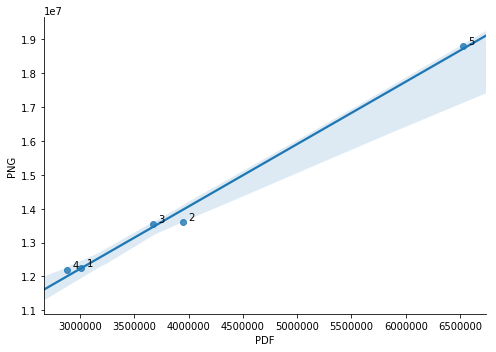

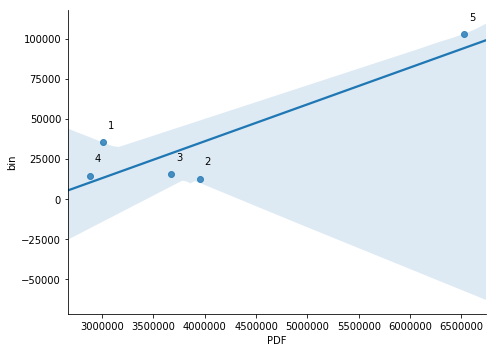

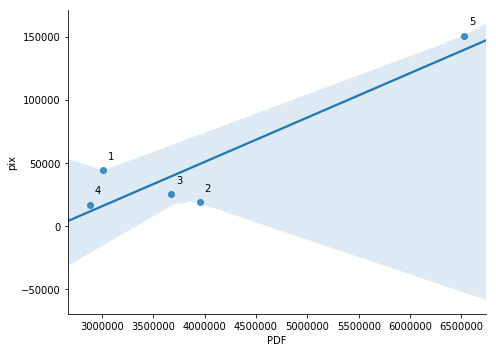

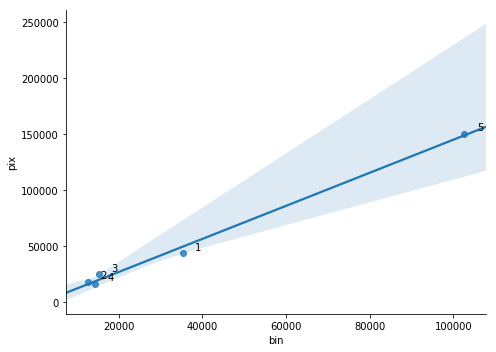

In [43]:
import ssl
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image, ImageDraw

data = pd.DataFrame({'lbl': [x for x in range(1, 6)], \
                    'PDF': [3010728, 3950069, 3671493, 2880959, 6528456], \
                    'PNG': [12242166, 13621059, 13554902, 12190349, 18805438], \
                    'bin': [35311, 12616, 15329, 14446, 102572]})

if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

negro = (0, 0, 0)
blanco = (255, 255, 255)
umbral = 90 
    
pix = []
for ejemplo in range(1, 6): # de uno a cinco
    url = 'https://elisa.dyndns-web.com/teaching/comp/datasci/ejemplo{:d}.png'.format(ejemplo)
    imagen = Image.open(requests.get(url, stream = True).raw) 
    n = imagen.convert('RGB') 
    w, h = n.size
    P = n.load()
    for f in range(h): # bordes verticales
        if P[0, f] == negro:
            ImageDraw.floodfill(n, (0, f), blanco)
        if P[w - 1, f] == negro:
            ImageDraw.floodfill(n, (w - 1, f), blanco)
    for c in range(w): # bordes horizontales
        if P[c, 0] == negro:
            ImageDraw.floodfill(n, (c, 0), blanco)
        if P[c, h - 1] == negro:
            ImageDraw.floodfill(n, (c, h - 1), blanco) 
    for f in range(h): 
        for c in range(w):
            rgb = P[c, f]
            if max(rgb) - min(rgb) > umbral: # tiene un color que no es gris 
                P[c, f] = blanco
    b = n.convert('1') # binaricemos lo que queda
    P = b.load()
    negros = 0
    for f in range(h): 
        for c in range(w):
            if P[c, f] == 0:
                negros += 1
    pix.append(negros)

data['pix'] = pix

# etiquetado de https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn
def label_point(x, y, xoffset, yoffset, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + xoffset, point['y'] + yoffset, str(point['val']))

sns.lmplot(x = 'PDF', y = 'PNG',data=data, fit_reg = True, height = 5, aspect = 1.4) 
label_point(data.PDF, data.PNG, 80000, 80000, data.lbl, plt.gca())
        
sns.lmplot(x = 'PDF', y = 'bin',data=data, fit_reg = True, height = 5, aspect = 1.4) 
label_point(data.PDF, data.bin, 50000, 9000, data.lbl, plt.gca())

sns.lmplot(x = 'PDF', y = 'pix',data=data, fit_reg = True, height = 5, aspect = 1.4) 
label_point(data.PDF, data.pix, 50000, 9000, data.lbl, plt.gca())
                             
sns.lmplot(x = 'bin', y = 'pix',data=data, fit_reg = True, height = 5, aspect = 1.4) 
label_point(data.bin, data.pix, 3000, 3000, data.lbl, plt.gca())                             

Según los tamaños de archivos, 
* 1 y 4 son parecidos en términos de contenido informativo
* 2 y 3 se parecen entre ellos y contienen más información que 1 y 4
* 5 contiene mucho más apuntes que los demás

En términos de los pixeles que naturalmente correlaciona con el tamaño del PNG binarizado (los valores blancos por lo general no se almacenan por ser el color de fondo), 
* 2, 3 y 4 son parecidos
* 1 tiene más información que esos tres
* 5 tiene muchos más apuntes que los demás
pero habrá que ver con nuestros propios ojos sí o no el juicio humano coindice con uno de estas clasificaciones. Para poder ver los cinco ejemplos de manera simultánea. Los PNG originales son muy grandes, por lo cual mejor los [escalo primero con ImageMagick](http://www.imagemagick.org/Usage/resize/) a 300 pixeles de ancho cada uno.

In [ ]:
convert ejemplo1.png -resize 300x600 ej1.png
convert ejemplo2.png -resize 300x600 ej2.png
convert ejemplo3.png -resize 300x600 ej3.png
convert ejemplo4.png -resize 300x600 ej4.png
convert ejemplo5.png -resize 300x1200 ej5.png

Ejemplo 1 | Ejemplo 2 | Ejemplo 3 | Ejemplo 4 | Ejemplo 5
- | - | - | - | -
![Ejemplo 1](https://elisa.dyndns-web.com/teaching/comp/datasci/ej1.png) | ![Ejemplo 2](https://elisa.dyndns-web.com/teaching/comp/datasci/ej2.png) | ![Ejemplo 3](https://elisa.dyndns-web.com/teaching/comp/datasci/ej3.png) | ![Ejemplo 4](https://elisa.dyndns-web.com/teaching/comp/datasci/ej4.png) | ![Ejemplo 5](https://elisa.dyndns-web.com/teaching/comp/datasci/ej5.png)

Una examinación visual revela rápidamente que 1 sí tiene más contenido que 2, 3, y 4. También 5 contiene fácil el doble de lo que contiene el 1. Al parecer el esfuerzo de binarización inteligente sí sirve, pero no es necesario contar los pixeles ya que el tamaño del archivo binarizado también basta, en el caso que se quiera almacenar los apuntes binarizados para otro tipo de análisis o procesamiento.

Pues, a descargar todos los apuntes para ver si sirve de algo en el caso de estudio esta idea. Primero se necesita obtener los PDF, luego convertirlos en PNG, combinar los PNG en el caso que fueron varios, y después procesar con Pillow. 

En el webserver, generé un listado de los apuntes existentes con 

ls -1 semana_*/*.pdf > apuntes_ad18.lst

para luego descargar los más de 600 PDFs con un bash y convertirlos en PNG con otro bash que primero saca los PNG de cada página individual y luego los une a uno sólo como se hizo con el quinto ejemplo (don't try this at home, tarda un buen porque son muchos archivos). Estoy procesando también las hojas de exámenes (semanas 8 y 16) para ver si la cantidad de contenido tiene relación o no con los resultados de esos mismos exámenes.

In [ ]:
prefix='https://elisa.dyndns-web.com/teaching/mat/discretas/ad18/'
while read filename;
do
    target=$(echo $filename | sed 's/\//_/g')
    curl -o $target $prefix$filename
done <apuntes_ad18.lst

In [ ]:
for pdf in `ls -1 semana_*_*.pdf`; do
    output=`basename $pdf .pdf`
    convert -verbose -density 150 -trim $pdf -quality 100 -flatten -sharpen 0x1.0  $output-%02d.png
    convert $output-*.png -append $output.png
    rm $output-*.png
done

In [ ]:
from PIL import Image, ImageDraw

negro = (0, 0, 0)
blanco = (255, 255, 255)
umbral = 90 
    
with open('apuntes_ad18.csv', 'w') as target:
    with open('imagenes.lst') as data:
        for filename in data:
            filename = filename.strip()
            print(filename)
            imagen = Image.open(filename)
            n = imagen.convert('RGB') 
            w, h = n.size
            P = n.load()
            for f in range(h): # bordes verticales
                if P[0, f] == negro:
                    ImageDraw.floodfill(n, (0, f), blanco)
                if P[w - 1, f] == negro:
                    ImageDraw.floodfill(n, (w - 1, f), blanco)
            for c in range(w): # bordes horizontales
                if P[c, 0] == negro:
                    ImageDraw.floodfill(n, (c, 0), blanco)
                if P[c, h - 1] == negro:
                    ImageDraw.floodfill(n, (c, h - 1), blanco)
            for f in range(h):
                for c in range(w):
                    rgb = P[c, f]
                    if max(rgb) - min(rgb) > umbral: # tiene un color que no es gris
                        P[c, f] = blanco
            b = n.convert('1') # binaricemos lo que queda
            P = b.load()
            negros = 0
            b.save('bw_' + filename)
            for f in range(h):
                for c in range(w):
                    if P[c, f] == 0:
                        negros += 1
            print(filename, negros, file = target)

Ahora hay que juntar esto en un CSV que dice para cada alumno cuantos pixeles de apuntes, o NA si no hubo, tiene por semana, para poder combinarlo con los datos que ya se tiene de los demás atributos.

Sequemos además cuál fue la primera clase en la cual tomó apuntes, cuál la última, cuántos de los pixeles fueron de exámenes y cuántos en total entre las 16 semanas.

In [ ]:
from collections import defaultdict
records = defaultdict(dict)
with open("apuntes_ad18.csv") as data:
    for line in data:
        line = line.strip()
        fields = line.split()
        week = int(fields.pop(0))
        student = fields.pop(0)
        pixels = int(fields.pop(0))
        if student.isdigit():
            records[student][week] = pixels
for student in records:
    classes = records[student].keys() - {8, 16}
    earliest = "NA"
    latest = "NA"
    if len(classes) > 1:
        latest = str(max(classes))
        earliest = str(max(classes))
    exams = records[student].get(8, 0) + records[student].get(16, 0)
    total = sum(records[student].values())
    print(student, ' '.join([str(records[student].get(week, "NA")) for week in range(1, 17)]), \
          earliest, latest, total, exams)

Ese último script de python genera este tipo de información:

In [ ]:
head apuntes_por_semana_ad18.csv 
..80354 1171277 970914 NA 38705 NA NA NA 482072 NA 23932 21011 NA NA NA NA 554240
..81516 21857 NA NA 29724 NA NA NA 482972 NA 26760 998452 1074450 NA NA NA 482840
..19569 20516 NA 27311 NA 11209 5156 NA 377872 29362 7281 NA NA NA NA NA 512929
..40266 NA NA 19300 NA NA NA NA NA NA 39694 NA NA NA NA NA 532292
..57232 1150887 1188296 NA 9014 NA NA 26892 497338 NA 29668 20210 NA NA NA NA 489892
..24712 33364 26388 NA NA NA NA NA 476408 NA 42678 NA NA NA NA NA 613232
..27009 34297 21438 1013660 54718 NA NA NA 468100 NA 31484 NA NA NA NA NA 559867
..27237 26039 29840 8521 27411 6621 15247 NA 478531 NA 34328 NA 27347 NA 7720 6333 497577
..27464 NA 1104950 1042213 NA NA NA NA 458541 NA 994515 25905 771574 37884 NA NA 620286
..29079 42554 9521 NA NA NA NA NA 396354 NA 36421 NA NA NA NA NA 484784

In [ ]:
import pandas as pd
d = pd.read_csv("casos.csv")
d.matr = d.matr.astype(int)
a = pd.read_csv("apuntes_por_semana_ad18.csv", header=None, sep=" ")
a.columns = ['matr'] + ['sem{:02d}'.format(s) for s in range(1, 17)] + ["earliest", "latest", "exams", "total"]
c = pd.merge(d, a, how='outer', on = ['matr'])
print(c.columns)
c.drop(['matr'], axis = 1) # algo de anonimidad                                                                                                                          
c.to_csv("combo.csv")

In [ ]:
head -n 1 combo.csv > elisa.csv
grep elisa combo.csv >> elisa.csv # los demás profes no tienen los datos de los apuntes anyhow

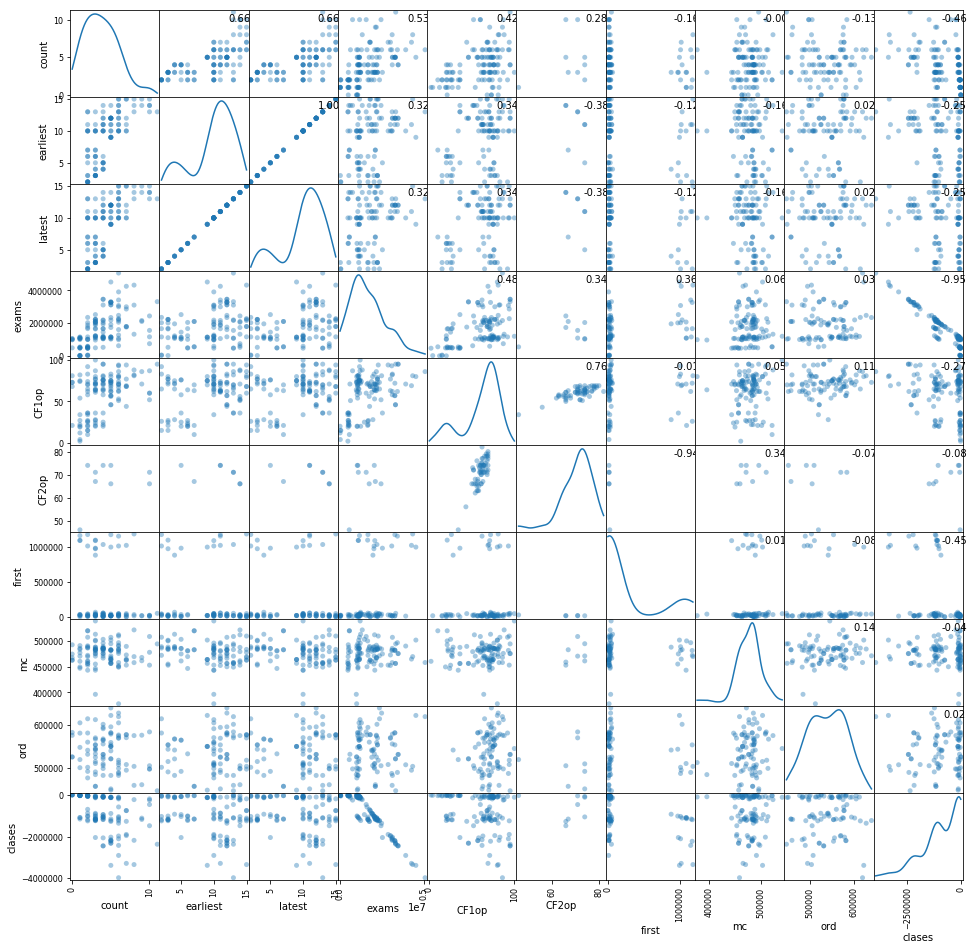

In [24]:
import ssl
import pandas as pd
from numpy import NaN
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
e = pd.read_csv("https://elisa.dyndns-web.com/teaching/comp/datasci/elisa.csv")
semanas = ['sem{:02d}'.format(s) for s in range(1, 17)]
e['CF1op'] = [int(str(x)) if str(x).isdigit() else NaN for x in e['1ra']] # no entran al análisis si son tipo object
e['CF2op'] = [int(str(x)) if str(x).isdigit() else NaN for x in e['2da']] 
# visualización nuevamente basada en la discusión de
# https://stackoverflow.com/questions/27768677/pandas-scatter-matrix-display-correlation-coefficient
e['first'] = e.sem01
e['mc'] = e.sem08
e['ord'] = e.sem16
e['clases'] = e.total - e.exams
e = e.drop(['total', 'Unnamed: 0', 'profe', '1ra', '2da'], axis = 1)
e = e.drop(semanas, axis = 1) # para no visualizar todas las semanas
ax = scatter_matrix(e, alpha = 0.4, figsize = (16, 16), diagonal = 'kde', s = 100)
c = e.corr().values
for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
    ax[i, j].annotate('{:.2f}'.format(c[i, j]), (0.9, 0.9), \
                      xycoords = 'axes fraction', ha = 'center', va = 'center')
plt.show()

Pues, el cuántos apuntes de clase hicieron naturalmente correlaciona con cuándo fueron entregados sus primeros y últimos apuntes. Pinta que los que escriben apuntes en varias clases escriben mucho en exámenes también, pero es muy ruidosa esa gráfica de dispersión, igual como lo de número de apuntes entregados contra la calificación de primera oportunidad. 

La gráfica de clases contra exams es interesante, con una correlación fuerte negativa: al parecer escribes menos en los exámenes si entregaste apuntes con mucho contenido. 

En el reporte de la última práctica, aplica algún tipo de procesamiento de imágenes. Si tus datos no contienen imágenes, agarra algún otro tipo de repositorio de interés para hacer pruebas. Documenta con figuras y estadísticas los resultados obtenidos.